# IPW v2: `Re78` - `Re75`

In [3]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import numpy as np
import statsmodels.formula.api as smf


def ipw(df, treatment_col, outcome_col, confounder_cols):
    """
    Estimate the causal effect of the treatment on the outcome using Inverse
    Probability Weighting (IPW).

    Parameters:
    - df (pd.DataFrame): The dataset containing the treatment, outcome, and
    confounder columns.
    - treatment_col (str): The name of the treatment column.
    - outcome_col (str): The name of the outcome column.
    - confounder_cols (list of str): A list of names of confounder columns.

    Returns:
    - effect (float): The estimated causal effect of the treatment on the outcome.
    """
    df_copy = df.copy()
    results = []
    treatments = sorted(np.unique(df_copy[treatment_col]))

    formula = f"{treatment_col} ~ " + " + ".join(confounder_cols)
    model = smf.mnlogit(formula=formula, data=df_copy).fit(disp=False)

    propensity_scores = model.predict(df_copy).reset_index(drop=True)
    df_copy["propensity"] = df_copy.apply(
        lambda row: propensity_scores.loc[row.name, int(row[treatment_col])], axis=1
    )
    df_copy["ipw"] = 1 / df_copy["propensity"]

    for a_val in treatments:
        df_a = df_copy.loc[df_copy[treatment_col] == a_val, :].reset_index(drop=True)
        weighted_mean = np.average(df_a[outcome_col], weights=df_a["ipw"])
        results.append(weighted_mean)

    return results[1] - results[0]


def prop_probs(df, treatment_col, confounder_cols):
    """
    Calculate propensity scores for each observation in the dataset.

    Parameters:
    - df (pd.DataFrame): The dataset containing the treatment and confounder
    columns.
    - treatment_col (str): The name of the treatment column.
    - confounder_cols (list of str): A list of names of confounder columns.

    Returns:
    - pd.DataFrame: A DataFrame containing the original data with an additional
    column for propensity scores.
    """
    df_copy = df.copy()

    formula = f"{treatment_col} ~ " + " + ".join(confounder_cols)
    model = smf.mnlogit(formula=formula, data=df_copy).fit(disp=False)

    propensity_scores = model.predict(df_copy).reset_index(drop=True)
    df_copy["propensity"] = df_copy.apply(
        lambda row: propensity_scores.loc[row.name, int(row[treatment_col])], axis=1
    )
    return df_copy[["id", "propensity"]]


def ipw_probs(df, treatment_col, confounder_cols):
    """
    Calculate inverse probability weights (IPW) for each observation in the dataset.

    Parameters:
    - df (pd.DataFrame): The dataset containing the treatment and confounder
    columns.
    - treatment_col (str): The name of the treatment column.
    - confounder_cols (list of str): A list of names of confounder columns.

    Returns:
    - pd.DataFrame: A DataFrame containing the original data with an additional
    column for IPW.
    """
    df_copy = prop_probs(df, treatment_col, confounder_cols)
    df_copy["ipw"] = 1 / df_copy["propensity"]

    return df_copy[["id", "ipw"]]

import numpy as np
from tqdm import tqdm


def bootstrap(df, function, n=50, ci=95, set_seed=True, **kwargs):
    """
    Perform bootstrap resampling to estimate the confidence interval of a statistic.

    Parameters:
    - df (pd.DataFrame): The dataset to resample from.
    - function (callable): The function to apply to each resampled dataset. It should take the DataFrame
                           as its first argument and any additional keyword arguments.
    - n (int): The number of bootstrap samples to draw. Default is 50.
    - ci (int): The desired confidence interval percentage. Default is 95.
    - set_seed (bool): Whether to set a random seed for reproducibility. Default is True.
    - **kwargs: Additional keyword arguments to pass to the function.

    Returns:
    - numpy.ndarray: An array containing the mean, lower confidence interval, and upper confidence interval.
    """
    if set_seed:
        np.random.seed(42)
    results = []

    for _ in range(n):
        # this will ensure our bootstrapped sample is the same length
        # with replacement: https://en.wikipedia.org/wiki/Bootstrapping_(statistics)
        new_df = df.sample(n=df.shape[0], replace=True)
        assert new_df.shape == df.shape  # same shape
        results.append(function(new_df, **kwargs))

    # CI calculations: https://statisticsbyjim.com/hypothesis-testing/bootstrapping/
    # E.g. 95% CI is 2.5% - 97.5%
    lower_percentile = (100 - ci) / 2
    upper_percentile = 100 - lower_percentile

    results_arr = np.array(results)
    lower_ci = np.percentile(results_arr, lower_percentile, axis=0)
    upper_ci = np.percentile(results_arr, upper_percentile, axis=0)
    mean_ = np.mean(results_arr)

    return np.array([mean_, lower_ci, upper_ci])


def bootstrap_experiment(df, function, num_exp=10, n=50, ci=95, **kwargs):
    """
    Conduct multiple bootstrap experiments to estimate the variability of the bootstrap estimates.

    Parameters:
    - df (pd.DataFrame): The dataset to resample from.
    - function (callable): The function to apply to each resampled dataset. It should take the DataFrame
                           as its first argument and any additional keyword arguments.
    - num_exp (int): The number of bootstrap experiments to run. Default is 10.
    - n (int): The number of bootstrap samples to draw in each experiment. Default is 50.
    - ci (int): The desired confidence interval percentage. Default is 95.
    - **kwargs: Additional keyword arguments to pass to the function.

    Returns:
    - numpy.ndarray: An array containing the bootstrap results for each experiment.
    """
    experiment_results = []

    for _ in tqdm(range(num_exp), desc=f"Running experiments"):
        ci_result = bootstrap(df, function, n=n, ci=ci, set_seed=False, **kwargs)
        experiment_results.append(ci_result)

    return np.array(experiment_results)


In [4]:
lalonde_exp = pd.read_csv("synthetic_exp.csv")
lalonde_obs = pd.read_csv("synthetic_observed.csv")

In [5]:
lalonde_exp["re78_re75"] = lalonde_exp["re78"] - lalonde_exp["re75"]
lalonde_obs["re78_re75"] = lalonde_obs["re78"] - lalonde_obs["re75"]

Our average treatment effect is now a difference of differences

$\beta = E[Y^a - Y^{a'}] = E[(Re_{78} - Re_{75})^{a} - (Re_{78} - Re_{75})^{a'}]$

## Experimental Data

In [6]:
ipw_results = bootstrap_experiment(
    df=lalonde_exp,
    function=ipw,
    num_exp=50,
    n=50,
    ci=95,
    treatment_col="treat",
    outcome_col="re78_re75",
    confounder_cols=[
        "age",
        "education",
        "black",
        "hispanic",
        "married",
        "re74",
        "re75",
    ],
)

Running experiments: 100%|██████████| 50/50 [03:50<00:00,  4.61s/it]


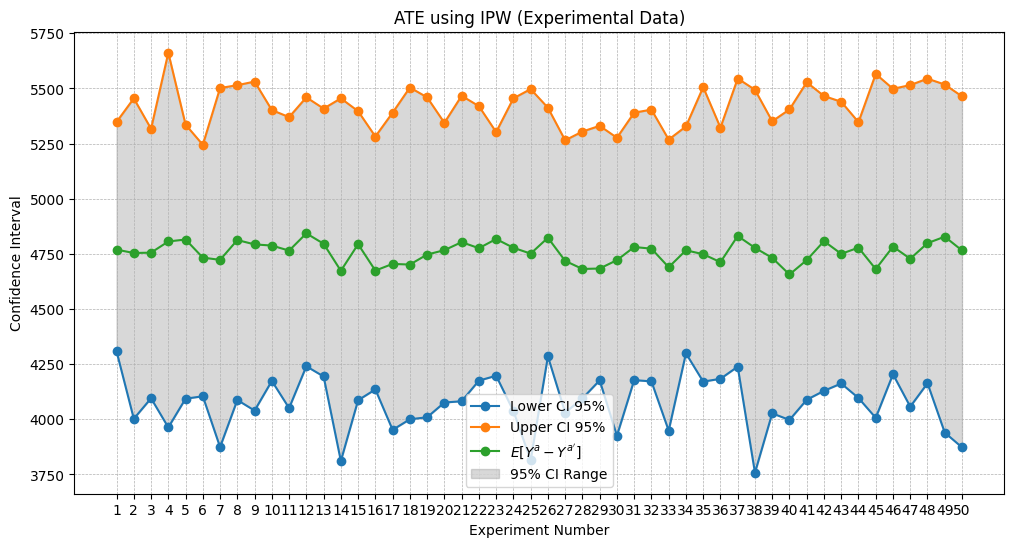

In [7]:
ci_df = pd.DataFrame(ipw_results, columns=["mean", "lower_ci", "upper_ci"])
ci_df["experiment"] = range(1, len(ci_df) + 1)

plt.figure(figsize=(12, 6))

plt.plot(ci_df["experiment"], ci_df["lower_ci"], label="Lower CI 95%", marker="o")
plt.plot(ci_df["experiment"], ci_df["upper_ci"], label="Upper CI 95%", marker="o")
plt.plot(ci_df["experiment"], ci_df["mean"], label="$E[Y^a - Y^{a'}]$", marker="o")

plt.fill_between(
    ci_df["experiment"],
    ci_df["lower_ci"],
    ci_df["upper_ci"],
    color="gray",
    alpha=0.3,
    label="95% CI Range",
)

plt.grid(True, which="both", linestyle="--", linewidth=0.5)
plt.xticks(ci_df["experiment"])
plt.xlabel("Experiment Number")
plt.ylabel("Confidence Interval")
plt.title("ATE using IPW (Experimental Data)")
plt.legend()
plt.show()

## Observational Data

In [8]:
ipw_results = bootstrap_experiment(
    df=lalonde_obs,
    function=ipw,
    num_exp=50,
    n=50,
    ci=95,
    treatment_col="treat",
    outcome_col="re78_re75",
    confounder_cols=[
        "age",
        "education",
        "black",
        "hispanic",
        "married",
        "re74",
        "re75"
    ],
)

Running experiments: 100%|██████████| 50/50 [03:52<00:00,  4.65s/it]


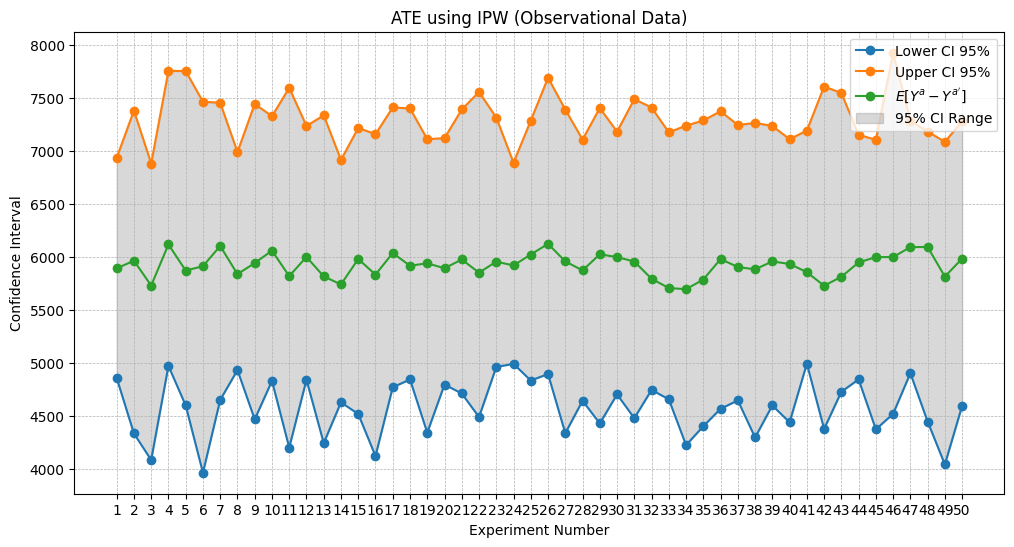

In [9]:
ci_df = pd.DataFrame(ipw_results, columns=["mean", "lower_ci", "upper_ci"])
ci_df["experiment"] = range(1, len(ci_df) + 1)

plt.figure(figsize=(12, 6))

plt.plot(ci_df["experiment"], ci_df["lower_ci"], label="Lower CI 95%", marker="o")
plt.plot(ci_df["experiment"], ci_df["upper_ci"], label="Upper CI 95%", marker="o")
plt.plot(ci_df["experiment"], ci_df["mean"], label="$E[Y^a - Y^{a'}]$", marker="o")

plt.fill_between(
    ci_df["experiment"],
    ci_df["lower_ci"],
    ci_df["upper_ci"],
    color="gray",
    alpha=0.3,
    label="95% CI Range",
)

plt.grid(True, which="both", linestyle="--", linewidth=0.5)
plt.xticks(ci_df["experiment"])
plt.xlabel("Experiment Number")
plt.ylabel("Confidence Interval")
plt.title("ATE using IPW (Observational Data)")
plt.legend()
plt.show()

Albeit, still low, we're seeing a better estimate.